In [1]:
%%capture
!pip install chitra
!pip install -U opencv-python

In [2]:
!gdown 10bLeDag7q9wU-mVpsz5EKR4HdHTwkVxf

Downloading...
From: https://drive.google.com/uc?id=10bLeDag7q9wU-mVpsz5EKR4HdHTwkVxf
To: /content/models_NN_for_face_extraction_200.zip
100% 22.6M/22.6M [00:00<00:00, 222MB/s]


In [3]:
%%capture
!unzip /content/models_NN_for_face_extraction_200.zip

In [4]:
%%capture
!gdown 16XcnEbSH4OijzCchTcZuyj3-KfXAdcAp
!gdown 1xB5ukiVDAr32TKH3Oz5ZvdIiVanhegl2

!unzip BIG_Celeb.zip -d ./celeb_data
!wget https://engineering.unl.edu/images/staff/Kayla-Person.jpg

In [5]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from random import randrange
from skimage import io
from PIL import Image 
import pandas as pd
import numpy as np
import pickle
import cv2
from chitra.image import Chitra
from tensorflow import keras
from sklearn.model_selection import train_test_split


In [6]:
### for feature extraction (BOWV) ###
feature_extractor = cv2.SIFT_create()
count = 0

### for bounding box generation ###
simple_nn = keras.models.load_model('/content/models/simple_dense')
simple_nn_skip = keras.models.load_model('/content/models/dense_with_skip')

In [7]:
def to_points_arrya(cur_lp_sift):
  return [list(cur_l.pt) for cur_l in cur_lp_sift]

def position_2d_to_1d(position):
  return position[:,0] * 200 + position[:,1]

def padd_array(cur_arr, max_size):
  return np.pad(cur_arr, (0, max_size - len(cur_arr)) ,'constant', constant_values=(-1))

def normalize_arr(arr, upper=512):
  diff = arr.max() - arr.min()
  min_v = arr.min()
  arr_norm = (arr - min_v) * (upper/diff)
  return arr_norm.astype(int)

In [10]:
def get_bowv_from_img(img_path):
  imagem_data = io.imread(img_path) 
  inicial_img_shape = imagem_data.shape
  imagem_data = cv2.cvtColor(imagem_data, cv2.COLOR_BGR2RGB)
  resize_img = cv2.resize(imagem_data, (200, 200))
  
  img_grey = cv2.cvtColor(imagem_data, cv2.COLOR_BGR2GRAY)
  resize_img_grey = cv2.resize(img_grey, (200, 200))


  points_vector, sift_vectors = feature_extractor.detectAndCompute(resize_img_grey, None)
  points_vector =  [list(cur_pos.pt) for cur_pos in points_vector]
  points_vector = np.array(points_vector, dtype=int)

  f_points_vector = position_2d_to_1d(points_vector)
  pad_truc = max([1516, len(f_points_vector)])
  f_points_vector = f_points_vector[:pad_truc]
  f_points_vector = padd_array(f_points_vector, 1516)
  f_points_vector = normalize_arr(f_points_vector)
  bowv = np.histogram(f_points_vector, bins=512, range=(1,512))[0]
  bowv = bowv/np.sum(bowv)

  return bowv, resize_img, inicial_img_shape

def increase_by(val, to_inc):
  val += val * to_inc
  return min(val, 480)  

def decrese_by(val, to_inc):
  val -= val * to_inc
  return max(val, 0)

def expand_box(box, by_p=0.2):
  box[0] = decrese_by(box[0], by_p)
  box[1] = decrese_by(box[1], by_p)

  box[2] = increase_by(box[2], by_p)
  box[3] = increase_by(box[3], by_p)

def get_prediction_for_image(img_path, display=False, exp_by=0.0):

  bowv, resized_img, inicial_img_shape = get_bowv_from_img(img_path)


  simple_nn_pred = simple_nn.predict(np.array([bowv]))[0] * 200
  simple_nn_skip_pred = simple_nn_skip.predict(np.array([bowv]))[0]  * 200
  
  expand_box(simple_nn_pred, exp_by)
  expand_box(simple_nn_skip_pred, exp_by)
  
  simple_nn_img = Chitra(np.array(resized_img), bboxes=simple_nn_pred, labels='face')
  simple_nn_img.resize_image_with_bbox((inicial_img_shape[1], inicial_img_shape[0]))
  
  skip_nn_img = Chitra(np.array(resized_img), bboxes=simple_nn_skip_pred, labels='face')
  skip_nn_img.resize_image_with_bbox((inicial_img_shape[1], inicial_img_shape[0]))

  return simple_nn_img, skip_nn_img

def plot_images(image_grad_boost, image_knn, plot_shape=(20,3), save_fig=False):
  global count
  plt.rcParams["figure.figsize"] = plot_shape
  fig, axs = plt.subplots(1,2)
  # fig.suptitle('images results')
  
  axs[0].imshow(cv2.cvtColor(image_grad_boost.draw_boxes(), cv2.COLOR_BGR2RGB))
  axs[0].set_title('Simple NN')
  axs[1].imshow(cv2.cvtColor(image_knn.draw_boxes(), cv2.COLOR_BGR2RGB))
  axs[1].set_title('Simple NN with skip')

  fig.patch.set_alpha(0.0)
  fig.show()
  if save_fig:
    cv2.imwrite('Simple NN.png', image_grad_boost.draw_boxes())
    cv2.imwrite('Simple NN with skip.png', image_knn.draw_boxes())

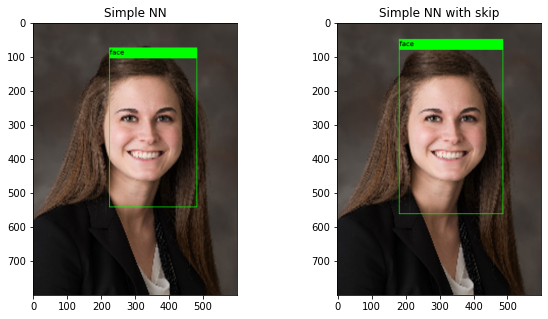

In [11]:
simple_nn_img, skip_nn_img = get_prediction_for_image('/content/Kayla-Person.jpg', exp_by=0.0)
plot_images(simple_nn_img, skip_nn_img, plot_shape=(10,5), save_fig=True)


In [13]:
df = pd.read_csv('/content/cebeldataset_big.csv')
_, df_test = train_test_split(df, test_size=0.3, random_state=42)
df_test.head(1)


,img_name,x1,y1,w,h,x2,y2
5809,./celeb_data/005810.jpg,430,691,1222,1692,1652,2383


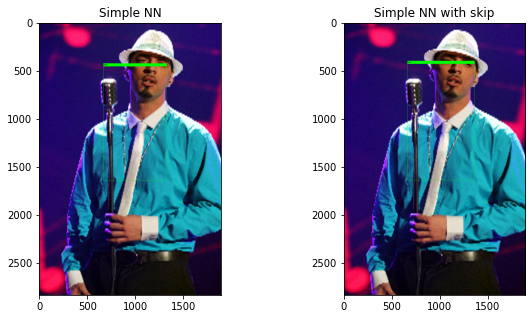

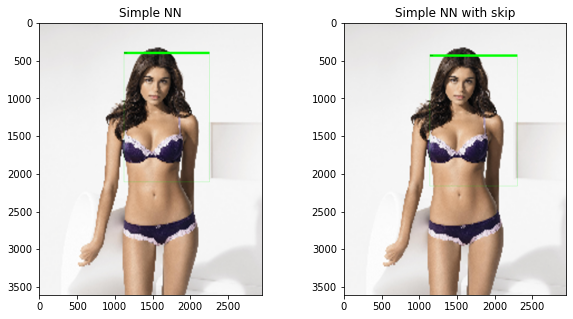

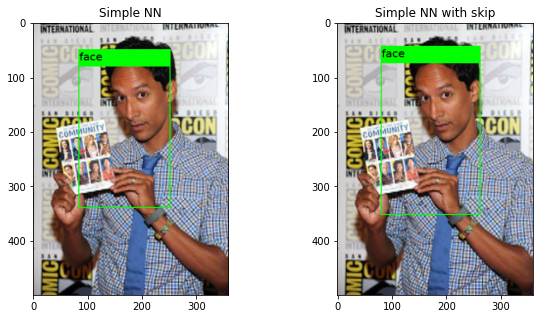

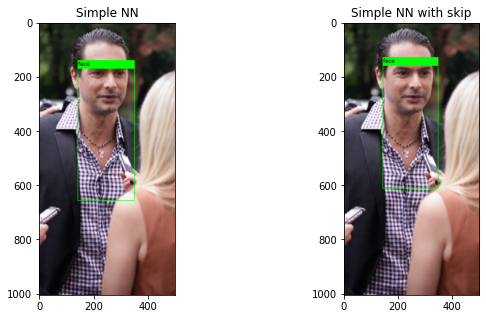

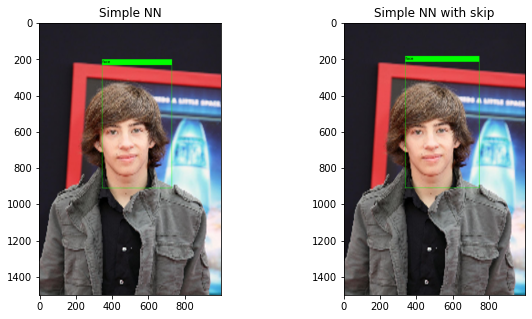

In [16]:
images_path = df_test['img_name'].sample(5,random_state=2).values

for cur_img_p in images_path:
  simple_nn_img, skip_nn_img = get_prediction_for_image(cur_img_p, exp_by=0.0)
  plot_images(simple_nn_img, skip_nn_img, plot_shape=(10,5), save_fig=True)

